#Homework 6
Part 1: Softmax

Part 2: Bayes: MAP estimator for continuous data

Part 3: Naive Bayes: Bayesian spam filter (discrete date)

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Part 1
When computing the output probabilities from margins $x_1,\ x_2,\ \ldots,\ x_C$, often (incorrectly) called *logits*, the exponential terms may be very large or very small. This can cause numerical or overflow errors (try `np.exp(1000)`).

Check that the following formula is correct for an arbitrary $A$:

$$
Softmax_i = \frac{e^{x_i}}{\sum\limits_{c=1}^{C} e^{x_c}} = \frac{e^{x_i-A}}{\sum\limits_{c=1}^{C} e^{x_c-A}}.
$$

A suitable choice for this fixed value $A$ is
$$
A = \underset{c}{\max} x_c.
$$

##Q1 (3pt) Write a function `compute_probabilities` that computes Softmax.

In [58]:
def compute_probabilities(X):
    """
    Computes Softmax, for each vector X[i, :].

    Args:
        X - (n, C) NumPy array (n datapoints each with C features)
    Returns:
        H - (n, C) NumPy array, where each row H[i,:] = Softmax(X[i,:])
    """
    relative = np.exp(X - np.max(X))

    soft_max = relative/np.sum(relative, axis=1, keepdims=True)
    return soft_max


In [59]:
#Test yourself
from scipy.special import softmax
M = np.random.randint(-1000, 1000, size=(30,20))
assert np.allclose(compute_probabilities(M), softmax(M, axis=1))

#Part 2
In this Question you will work with dataset from Ch.2 in *Classification, Parameter Estimation and State
Estimation: An Engineering Approach Using MATLAB* by
R. Duin, F. van der Heijden, D. de Ridder, and D. M.
J. Tax https://go.exlibris.link/Y6BQ8cJ5

In [60]:
#data = pd.read_csv('data_bnrs.csv', header=None)
data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2023_fall/data_bnrs.csv', header=None)

In [61]:
data.head()

,0,1,2
0,0.35029,0.79978,1
1,0.60302,0.97778,1
2,0.32696,0.74125,1
3,0.35015,0.83668,1
4,0.46741,0.94682,1


In [62]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

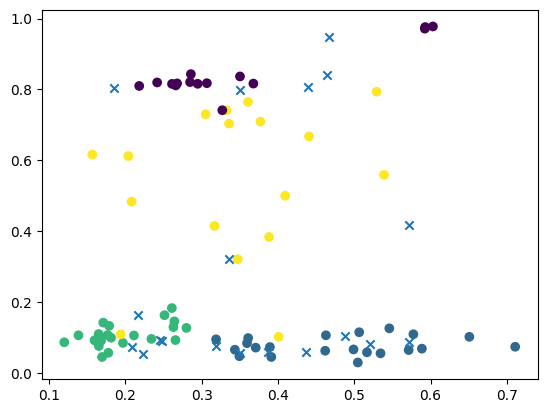

In [64]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.scatter(X_test[:,0], X_test[:,1], marker='x')

From the conditional probability formula, we know that
$$
p(y=c|x) = \frac{p(x, y=c)}{p(x)} = \frac{p(x|y=c)p(y=c)}{p(x)}, \quad c=1,2,3,4.
$$

Because the denominator doesn't depend on $c,$
$$
a(x) = \underset{c}{argmax}\ p(y=c|x) = \underset{c}{argmax}\ p(x|y=c)p(y=c).
$$

We will assume that conditional distribution $p(x|y=c)\sim N(\mu_c,\Sigma_c)$ you can use `multivariate_normal` from `scipy.stats` to calculate this value for the entier matix $X$ with datapoints in rows $X[i,:]$ as follows: `multivariate_normal(X, mean=, cov=)`.

For the Cost function, you can use the following decision rule:
$$
a(x) = argmin\ \text{Cost_Matrix}\cdot \begin{bmatrix}p(y=1|x)\\ p(y=2|x) \\ p(y=3|x)\\ p(y=4|x)\end{bmatrix} = argmin\ \text{Cost_Matrix}\cdot \begin{bmatrix}p(x|y=1)p(y=1)\\ p(x|y=2)p(y=2) \\ p(x|y=3)p(y=3)\\ p(x|y=4)p(y=4)\end{bmatrix}.
$$

##Q2 (8pt) Write the class `UserMAP` for maximum a posteriori estimator

In [78]:
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

In [83]:
class UserMAP():
    def __init__(self, cost=False):
        self.cost = cost
        self.mu0 = None
        self.sigma0 = None
        self.mu1 = None
        self.sigma1 = None
        self.mu2 = None
        self.sigma2 = None
        self.mu3 = None
        self.sigma3 = None


        self.p0 = 0
        self.p1 = 0
        self.p2 = 0
        self.p3 = 0

    def fit(self, X, y):
      """
      Calculate mean velues and covariance matrices for each class
      Calculate class distribution p(y)
      Store them as self. variables
      """
      self.m0 = X[y==0,:].mean(axis=0)
      self.sigma0 = np.cov(X[y==0,:].T)

      self.mu1 = X[y==1,:].mean(axis=0)
      self.sigma1 = np.cov(X[y==1,:].T)

      self.m2 = X[y==2,:].mean(axis=0)
      self.sigma2 = np.cov(X[y==2,:].T)

      self.mu3 = X[y==3,:].mean(axis=0)
      self.sigma3 = np.cov(X[y==3,:].T)

      labels, counts = np.unique(y, return_counts=True)
      self.p0, self.p1, self.p2, self.p3 = counts/len(y)

    def posterior(self, X): #false cost
      """
      Calculate posterior pobabilities and return argmax
      """
      return np.argmax(np.dstack((multivariate_normal.pdf(X, mean=self.mu0, cov=self.sigma0)*self.p0, multivariate_normal.pdf(X, mean=self.mu1, cov=self.sigma1)*self.p1,
                                  multivariate_normal.pdf(X, mean=self.mu2, cov=self.sigma2)*self.p2, multivariate_normal.pdf(X, mean=self.mu3, cov=self.sigma3)*self.p3,))[0], axis=1)

    def posterior_cost(self, X): #true cost
      """
      Given the cost matrix and posterior probabilities, predict the class
      """
      cost_matrix = np.array([
        [ -0.20, 0.07, 0.07, 0.07 ],
        [  0.07,-0.15, 0.07, 0.07 ],
        [  0.07, 0.07,-0.05, 0.07 ],
        [  0.03, 0.03, 0.03, 0.03 ]])

      v = np.array([[multivariate_normal.pdf(X, mean=self.mu0, cov=self.sigma0)*self.p0],
                    [multivariate_normal.pdf(X, mean=self.mu1, cov=self.sigma1)*self.p1],
                    [multivariate_normal.pdf(X, mean=self.mu2, cov=self.sigma2)*self.p2],
                    [multivariate_normal.pdf(X, mean=self.mu3, cov=self.sigma3)*self.p3]])

      return np.argmin(np.dot(cost_matrix, v))



    def predict(self, X):
      if self.cost == True:
        return self.posterior_cost(X)
      return self.posterior(X)

In [84]:
from mlxtend.plotting import plot_decision_regions

In [85]:
clf = UserMAP()

In [88]:
clf.fit(X_train, y_train)


y_pred = clf.predict(X)
accuracy_score(y,y_pred)

<ipython-input-83-b7ed51588ee6>:25: RuntimeWarning: Mean of empty slice.
  self.m0 = X[y==0,:].mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
<ipython-input-83-b7ed51588ee6>:26: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.sigma0 = np.cov(X[y==0,:].T)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

ValueError: array must not contain infs or NaNs

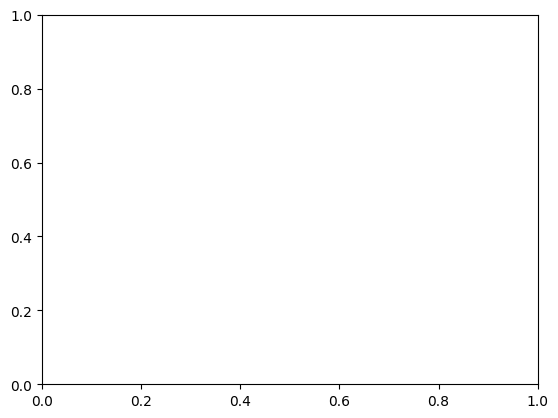

In [87]:
plot_decision_regions(X_test,y_test,clf)

In [ ]:
clf_cost = UserMAP(cost=True)

In [ ]:
clf_cost.fit(X_train, y_train)

In [ ]:
plot_decision_regions(X_test,y_test,clf_cost)

# Part 3
In this Question, you will apply Naive Bayes classifier to build a spam filter. Use dataset from https://www.kaggle.com/datasets/venky73/spam-mails-dataset?select=spam_ham_dataset.csv  It's *Enron email dataset,* a large collection of emails from the Enron Corporation.

In [ ]:
#!unzip spam_ham_dataset.csv.zip

In [ ]:
import pandas as pd
data = pd.read_csv('spam_ham_dataset.csv')

texts = data['text'].values
target = data['label_num'].values
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

Apply `CountVectorizer()` to the training data.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vec = CountVectorizer()

In [ ]:
X_train_bow = vec.fit_transform(texts_train).toarray()
X_test_bow = vec.transform(texts_test).toarray()

Now you have the counts of the words from the bag of words in each e-mail.

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier.
Its a simple probabilistic model that assumes the independence of input features and computes the counting probabilities.

If you don't remember the math behind Naive Bayes, read https://scikit-learn.org/stable/modules/naive_bayes.html to help refresh your memory. Done? Good! Now let's implement that :)

For every word we will calculate its frequency in spam and in ham, it will be $p(word|y=0)$ and $p(word|y=0)$. To avoid devisions by zero instead of the formula
$$
p(word|y) =\frac{\#word \text{ in class y}}{\text{total # words in class } y}
$$
use
$$
p(word|y) =\frac{\delta+\#word \text{ in class y}}{\delta\cdot\text{vocabulary length} + \text{total # words in class } y}
$$

##Q3 (8pt) Write the class for Naive Bayes

In [ ]:
delta = 1.0
class BinaryNaiveBayes:
#     delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=c) for c = 0,1
        self.p_y = #(<YOUR CODE: probability of y=0 and of y=1 in this order>)


        # count occurences of each word in texts with label 1 and label 0 separately
        word_counts_positive = #<YOUR CODE HERE>
        word_counts_negative = #<YOUR CODE HERE>
        # ^-- both must be vectors of shape [vocab_size].

        # finally, lets use those counts to estimate p(x | y = c) for c = 0, 1

        #<YOUR CODE HERE>

        self.p_x_given_positive = #<...>

        self.p_x_given_negative = #<...>
        # both must be of shape [vocab_size]; and don't forget to add self.delta!

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}

        score_negative = X.dot(np.log(self.p_x_given_negative)) + np.log(self.p_y[0])
        score_positive = X.dot(np.log(self.p_x_given_positive)) + np.log(self.p_y[1])
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [ ]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [ ]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. (The log of that fraction is called *logit.*) Here are top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$.

In [ ]:
bow_vocabulary = vec.get_feature_names_out()

In [ ]:
probability_ratio = 1/(naive_model.p_x_given_positive/naive_model.p_x_given_negative)
top_negative_words = bow_vocabulary[np.argsort(probability_ratio)[:25]]
assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[list(bow_vocabulary).index(word)]})")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, naive_model.predict(X_test_bow))

Now, let's do it with the built-in function and compare results

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model = #<YOUR CODE HERE - train a built-in Naive Bayes>

In [ ]:
np.mean(y_test==model.predict(X_test_bow))

Now lets try something less prehistoric: __Logistic Regression__. It turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

You can play with parameter $C=$ in LogisticRegression, it plays similar role as in SVM allowing slightly negative margins.

In [ ]:
from sklearn.linear_model import LogisticRegression
bow_model = #<YOUR CODE HERE - train a logistic regression>

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, bow_model.predict(X_test_bow))

Finally, you can play with threshold to reduce the False Positive predictions, as you did in HW5. But let's better think about

##Q4 (1pt) How to update the Naive Bayes model after getting a new spam classification from a user?